In [1]:
#### load packages, *.h5 folder and exp.h5 file location
%matplotlib widget

from essential_func import *
from analysis_data  import *
from ipywidgets     import fixed

qgrid2 = np.hstack([np.arange(0.005, 0.0499, 0.001), np.arange(0.05, 0.099, 0.002), np.arange(0.1, 3.2, 0.005)])

default_sample_dir =  'Mar-2023-Sample#1898'  #  'Mar-2023-Misc'    #'July-sorted'  # '20-Dec' # 'July-2021-Sample#6'   'Mar-2023-Sample#1898'
csv_and_code_abs_directory = '/Users/bashit.a/Documents/Alzheimer/Codes/'
samples_csv = 'data_directory.csv'

_,dropdown_name_list, cwd, exp_folder = change_python_path(dropdown_name = default_sample_dir, csv_file_location = csv_and_code_abs_directory, samples_csv = samples_csv)

Python directory is set to load samples from : Mar-2023-Sample#1898


blue-> Lesion - Tissue Sub Bkg Sub ; Orange --> Lesion - Bkg Sub ; Green --> Scaled (Tissue - Bkg)


interactive(children=(SelectionSlider(continuous_update=False, description='Frame', layout=Layout(width='50%')…

Checkbox(value=False, description='Add Selected Tissue ')

Output()

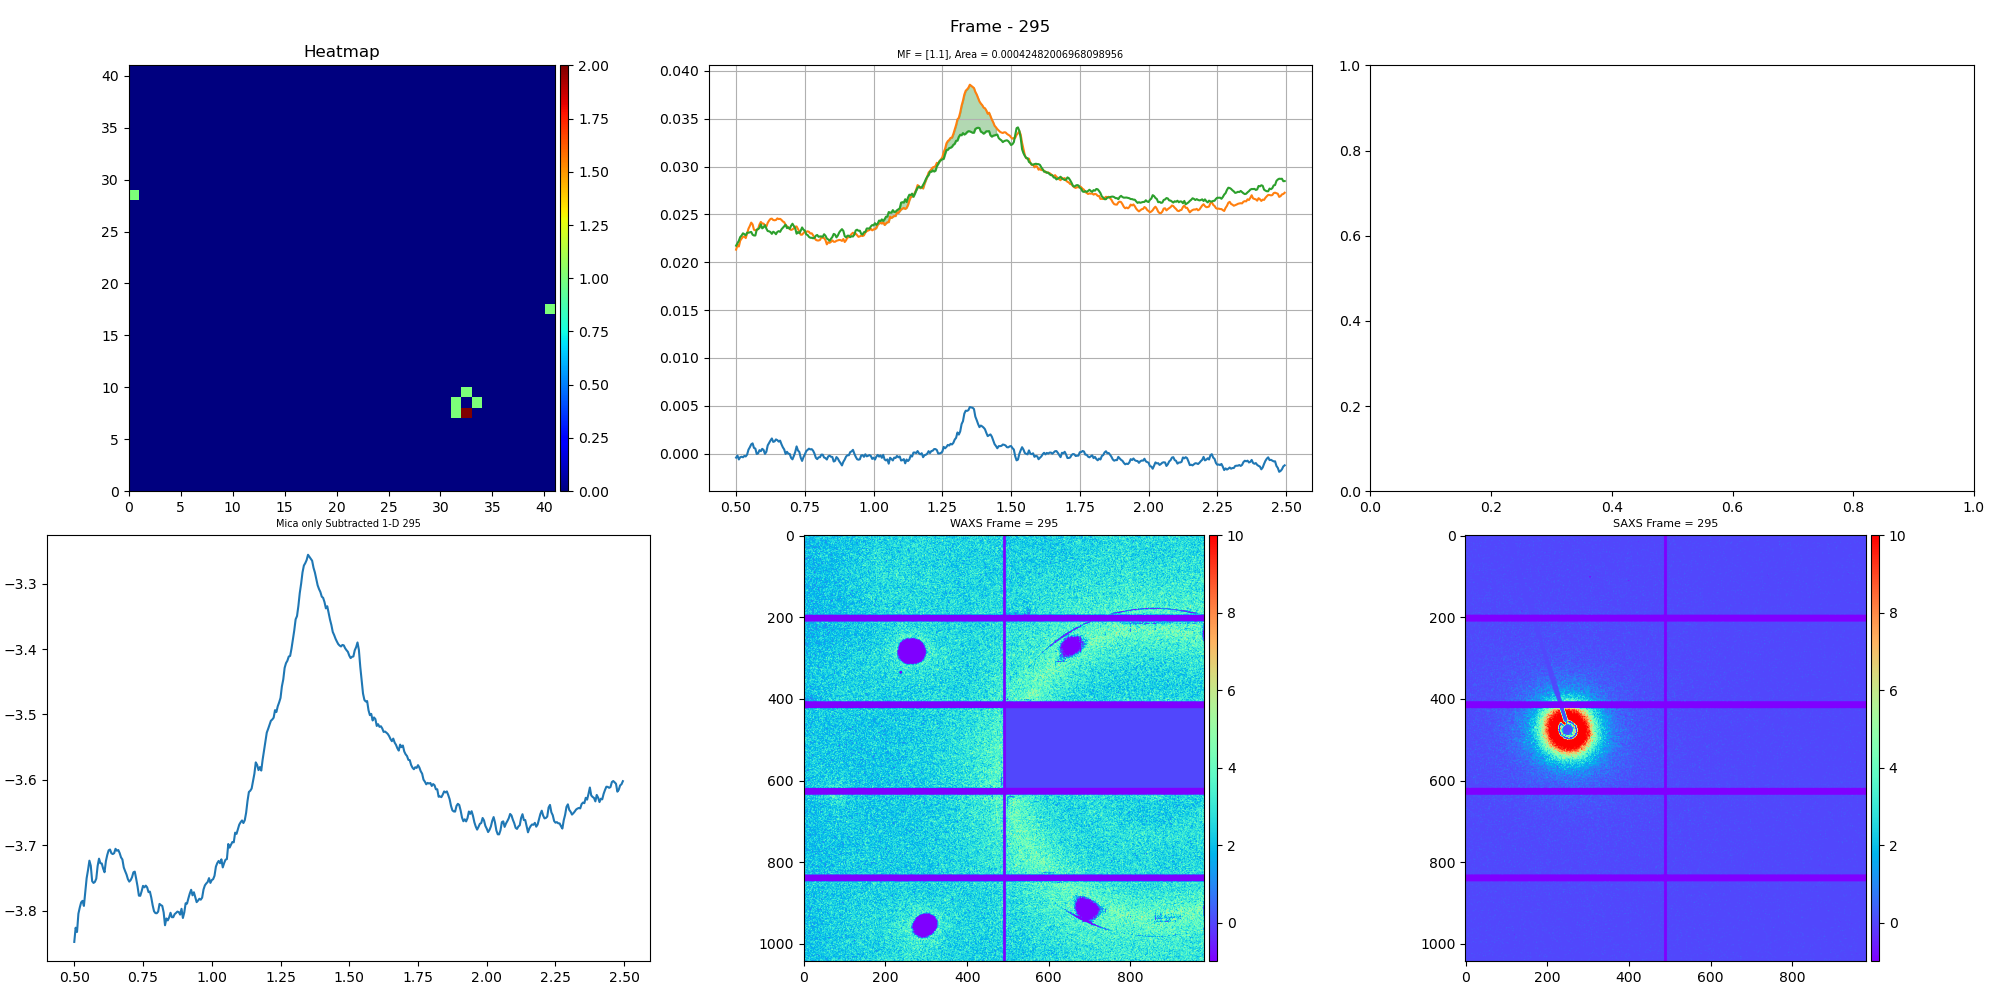

In [2]:
### background subtraction - renewed
%matplotlib widget
out = ipywidgets.Output()

# QSearchStart, QSearchEnd = 1.55, 1.8           # scaling regions 295,310 or may be 290,370
# frame = 2428 #7048                             # amyloid frame    2428, 3101, 3923, 2190,  691, 1134, 458
# tissue_frames = [6296,]                        # tissue frame
# bkg_frames = [6000, 6001, 6002, 6003 ] # 973   # background frame
# area_minQ = 1.0
# area_maxQ = 1.45
# mf_max = 2.5           # mf must be less than this value
# mf_min = 1.0           # mf must be greater than this value

file     = "1898_CING-roi0_0_0_masked_intp.h5"    # "1898_CING-roi0_0_0_masked_intp.h5"  --> 379 "2048_B8_masked.h5"  --> 1362
bkg_file = None                                   # None "1898_CING-roi0_0_0_masked_intp.h5"
bkg_dir  = None  # None  "/Volumes/HDD/BNL-Data/Mar-2023/1898/"

Width, Height = width_height(file)    # considering the fact that width and height is same for source and masked file
n_patterns    = Width*Height
test_frames   =  [295, 296, 359, 361, 377, 697, 1148]  # "1898_CING-roi0_0_0_masked_intp.h5" -> [295, 296, 359, 361, 377, 697, 1148]   "2048_B8_masked.h5"  --> [2068, 2079]
test_frames   = np.arange(0, n_patterns-1) if not test_frames else test_frames
tissue_frames = flatten([[1593, 1594, 1598, 1439,1430, 1276]])  # None "1898_CING-roi0_0_0_masked_intp.h5" -> flatten([[1593, 1594, 1598, 1439,1430, 1276]])  "2048_B8_masked.h5"  --> flatten([[2061, 2085]])

frame         = ipywidgets.SelectionSlider(options=test_frames,  value=test_frames[0],    description = "Frame", continuous_update=False, layout=ipywidgets.Layout(width='50%'))
if not tissue_frames:    
    tissue_frames = ipywidgets.IntsInput(min=0, max=n_patterns-1, value=[0], format='d', description = "Tissue", continuous_update=False)    # description    = "bkg_frames",
else:
    tissue_frames = ipywidgets.SelectMultiple(options=tissue_frames, value=[tissue_frames[0]],  description = "Tissue",continuous_update=False)  # description = "tissue_frames",
bkg_frames = ipywidgets.IntsInput(min=0, max=n_patterns-1, value=[], format='d', description = "Bkg", continuous_update=False)    # description    = "bkg_frames",

plot_q     = ipywidgets.FloatRangeSlider( value=(0.5, 2.5), min=qgrid2[0],   max=qgrid2[-1], step=0.005,    description='plot_q:',  disabled=False,  continuous_update=False,  orientation='horizontal',  readout=True, readout_format='.3f',layout=ipywidgets.Layout(width='50%') )
fit_q_range   = ipywidgets.FloatRangeSlider( value=(1.55, 1.85), min=qgrid2[0],   max=qgrid2[-1], step=0.005,   description='fit_q:',  disabled=False,  continuous_update=False,  orientation='horizontal',  readout=True, readout_format='.3f',layout=ipywidgets.Layout(width='50%') )
area_q     = ipywidgets.FloatRangeSlider( value=(1.0, 1.45), min=qgrid2[0],   max=qgrid2[-1], step=0.005,    description='area_q:',  disabled=False,  continuous_update=False,  orientation='horizontal',  readout=True, readout_format='.3f',layout=ipywidgets.Layout(width='50%') )
selected_tissue = []
ch = ipywidgets.Checkbox(value=False, description='Add Selected Tissue ',)

seek_mf     = (-12,12,0.01)        #gray       # mf goes from -8 to +8 by 0.01
window_size = 4                                # window size for moving average filter

plt.close('all')
f, axs = plt.subplots(nrows=2, ncols=3, num=file, figsize=(20,10))
data   = Data_Analysis(file, qgrid2, window_size=window_size, directory=os.getcwd())

@out.capture(clear_output=True)
def bkg_tissue_sub(frame, tissue_frames, bkg_frames, fit_q_range, area_q, seek_mf, window_size, plot_q, f, axs):
    ch.value = False
    print('selected tissue so far:', flatten(selected_tissue))
    area_minQ, area_maxQ = area_q
    plot_minQ, plot_maxQ = plot_q
    idx_start, idx_end = qgrid_to_indices(qgrid2, plot_minQ) , qgrid_to_indices(qgrid2, plot_maxQ)
    
    ### Tissue scaled background subtraction
    print(frame, tissue_frames)
    Iq              = data.bkg_sub(bkg_frame = bkg_frames, bkg_file=bkg_file, bkg_dir= bkg_dir)
    mf,area         = data.tissue_sub(frame, tissue_frames, mf_Qindices = fit_q_range, tissue_input = False, method = 'MSE', area_minQ= area_minQ, area_maxQ = area_maxQ,  seek_mf = seek_mf, show_result=True)

    [ax.clear() for ax in axs.flatten()]
    diff_patterns = np.zeros(Width*Height)
    diff_patterns[test_frames] = 1
    diff_patterns[frame] = 2
    plot_heat_map_from_data(snaking(Width, Height, diff_patterns), Width, Height, args = (f,axs[0,0]), title= f'Heatmap', cmap="jet")
    
    data.plot(frame, ax=axs[0,1], plot_minQ=plot_minQ, plot_maxQ=plot_maxQ, show_legend=False)
    
    ### plot IqBS 1-D data
    axs[1,0].plot(data.qgrid[idx_start:idx_end], np.log(data.IqBS[data.input_fr,idx_start:idx_end].flatten()))
    axs[1,0].set_title(f'Mica only Subtracted 1-D {data.input_fr}', fontsize=7)

    ### plot SAXS and WAXS images
    waxs_diff_image(data.file, data.input_fr, f=f, ax=axs[1,1])
    saxs_diff_image(data.file, data.input_fr, f=f, ax=axs[1,2])

    # plt.close()
@out.capture(clear_output=False)
def update_sel_tissue(ch):
    if ch:
        selected_tissue.append(list(tissue_frames.value))
    print('selected tissue so far:', flatten(selected_tissue))
ipywidgets.interactive(update_sel_tissue,ch=ch)

inputs= ipywidgets.interactive(bkg_tissue_sub, frame=frame, tissue_frames=tissue_frames, bkg_frames=bkg_frames, fit_q_range= fit_q_range, area_q= area_q, seek_mf=fixed(seek_mf), window_size=fixed(window_size), plot_q=plot_q, f=fixed(f), axs=fixed(axs))
print('blue-> Lesion - Tissue Sub Bkg Sub ; Orange --> Lesion - Bkg Sub ; Green --> Scaled (Tissue - Bkg)')
display(inputs,ch)
display(out)

In [260]:
qvalues = np.array([0. , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.  ])

MF =  [[0.97]
 [0.95]
 [1.13]
 ...
 [0.85]
 [0.89]
 [0.94]] AREA: 1.0~1.45 =  [1.70542823e-04 1.17889874e-04 2.56017484e-05 ... 8.39230650e-05
 2.06284784e-05 4.56610101e-05]
(300,) (300,) (1,)


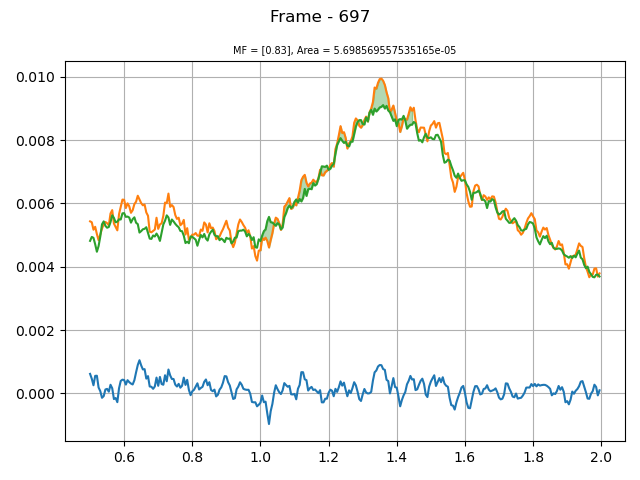

In [5]:
%matplotlib widget

f, ax = plt.subplots()
area_minQ, area_maxQ = 1., 1.45
plot_minQ, plot_maxQ = 0.5, 2.0
seek_mf              = (-12,12,0.01)        #gray       # mf goes from -8 to +8 by 0.01
fit_q_range          = 1.55, 1.85

data   = Data_Analysis(file, qgrid2, window_size=window_size, directory=os.getcwd())
Iq              = data.bkg_sub(bkg_frame = 379, bkg_file=None, bkg_dir= None)
mf,area         = data.tissue_sub(input_fr=np.arange(0,n_patterns,1).tolist(), tissue_fr=tissue, mf_Qindices = fit_q_range, tissue_input = True, method = 'MSE', area_minQ= area_minQ, area_maxQ = area_maxQ,  seek_mf = seek_mf, show_result=True)

data.plot(plot_fr=697, ax=ax, plot_minQ=plot_minQ, plot_maxQ=plot_maxQ, show_legend=False)

In [4]:
tissue = [ -1.38075472e+02 ,-1.55234144e+02 ,-1.61270985e+02 ,-6.98761453e+01,-2.40185539e+01 ,-5.95131598e+00 , 1.51946681e+00 , 4.29043153e+00, 5.20182859e+00 , 5.51470106e+00 , 5.21945200e+00 , 4.83785840e+00, 4.36871071e+00 , 3.98022163e+00 , 3.48159767e+00 , 3.01150740e+00, 2.61564767e+00 , 2.24350847e+00 , 1.97602427e+00 , 1.73188049e+00, 1.50370396e+00 , 1.30625237e+00 , 1.13784243e+00 , 9.82223266e-01, 8.45349418e-01 , 7.45644073e-01 , 6.82372118e-01 , 6.18368503e-01, 5.40924383e-01 , 4.70161108e-01 , 4.20685686e-01 , 3.56410212e-01, 3.15556309e-01 , 2.85488324e-01 , 2.51625816e-01 , 2.25960683e-01, 2.12080356e-01 , 1.94826704e-01 , 1.85004667e-01 , 1.66637498e-01, 1.61904631e-01 , 1.47364899e-01 , 1.27624274e-01 , 1.18779262e-01, 1.04557001e-01 , 9.82859332e-02 , 9.08994394e-02 , 8.24277284e-02, 7.36236746e-02 , 6.07588672e-02 , 5.00339930e-02 , 5.05202590e-02, 4.55065849e-02 , 4.26733100e-02 , 4.29749418e-02 , 3.48074075e-02, 3.33196077e-02 , 3.13038928e-02 , 2.53078006e-02 , 2.55725659e-02, 2.36032966e-02 , 2.24358636e-02 , 2.39521664e-02 , 2.40487524e-02, 2.33347756e-02 , 2.26098265e-02 , 2.22438093e-02 , 2.13498540e-02, 2.08931659e-02 , 2.01580790e-02 , 1.94228030e-02 , 1.79320718e-02, 1.63571794e-02 , 1.51080858e-02 , 1.33441816e-02 , 1.23881095e-02, 1.16265841e-02 , 1.09226218e-02 , 1.05975709e-02 , 9.80092565e-03, 9.18308737e-03 , 8.79153514e-03 , 8.46869221e-03 , 8.50486904e-03, 8.07174846e-03 , 8.22593762e-03 , 8.13035184e-03 , 7.50296734e-03, 7.34636383e-03 , 6.96885979e-03 , 6.40234110e-03 , 6.61178084e-03, 6.58364415e-03 , 6.53502389e-03 , 6.71374653e-03 , 6.32280533e-03, 6.52429447e-03 , 6.03071786e-03 , 6.07846712e-03 , 6.12257050e-03, 5.69692034e-03 , 6.33832886e-03 , 5.85081339e-03 , 5.96363726e-03, 5.82594169e-03 , 4.61360006e-03 , 4.60080299e-03 , 4.80564486e-03, 5.12907845e-03 , 5.38887263e-03 , 5.62470206e-03 , 5.79631060e-03, 5.65655982e-03 , 5.69153078e-03 , 5.17161846e-03 , 4.36060436e-03, 4.79950743e-03 , 4.90669571e-03 , 5.08408844e-03 , 5.61569810e-03, 5.30945622e-03 , 5.54440262e-03 , 5.83278971e-03 , 5.69315634e-03, 5.63632937e-03 , 5.30484352e-03 , 5.12823297e-03 , 4.80602006e-03, 4.81408410e-03 , 4.97126185e-03 , 4.96571306e-03 , 5.24499896e-03, 5.12336782e-03 , 5.39060422e-03 , 5.26429751e-03 , 5.22172323e-03, 4.92195767e-03 , 4.91521152e-03 , 5.39444595e-03 , 5.53083495e-03, 6.01356695e-03 , 5.69970659e-03 , 5.37071952e-03 , 5.21409991e-03, 5.25968327e-03 , 5.48749637e-03 , 5.63384259e-03 , 5.52164088e-03, 5.43575764e-03 , 5.55165065e-03 , 5.80501480e-03 , 5.95551111e-03, 5.92064460e-03 , 5.67370719e-03 , 5.39104851e-03 , 5.60740989e-03, 5.96989252e-03 , 6.43507023e-03 , 6.54734881e-03 , 6.37561011e-03, 6.30561596e-03 , 6.33255870e-03 , 6.51908642e-03 , 6.77906836e-03, 6.67896300e-03 , 6.50940443e-03 , 6.53945489e-03 , 6.62591722e-03, 6.61808972e-03 , 6.85288720e-03 , 6.86058918e-03 , 6.71779449e-03, 6.73056580e-03 , 6.69144535e-03 , 6.49826413e-03 , 6.63079163e-03, 6.70132220e-03 , 6.49467590e-03 , 6.44258838e-03 , 6.12075107e-03, 6.17664464e-03 , 6.24680034e-03 , 6.26395206e-03 , 6.32410749e-03, 6.10322182e-03 , 5.89139903e-03 , 5.87897695e-03 , 6.01113297e-03, 5.97086166e-03 , 6.08290772e-03 , 5.97379376e-03 , 5.80376663e-03, 6.11840855e-03 , 6.43030037e-03 , 6.57289122e-03 , 6.77646603e-03, 6.69491362e-03 , 6.41339778e-03 , 6.61808130e-03 , 6.54472090e-03, 6.45404050e-03 , 6.37936873e-03 , 6.32303369e-03 , 6.18229780e-03, 6.17268874e-03 , 6.00220234e-03 , 5.72232845e-03 , 5.77467625e-03, 5.71468708e-03 , 5.97316030e-03 , 5.96150216e-03 , 5.90623653e-03, 5.84669528e-03 , 5.61977478e-03 , 5.84544424e-03 , 6.02958964e-03, 5.93700662e-03 , 6.06711917e-03 , 5.89384647e-03 , 5.81562789e-03, 6.04931992e-03 , 6.15432271e-03 , 6.22732308e-03 , 6.03522013e-03, 5.98178068e-03 , 5.98256155e-03 , 5.83104729e-03 , 5.89445515e-03, 5.84503796e-03 , 5.75772332e-03 , 5.92322577e-03 , 5.88092230e-03, 5.89851093e-03 , 5.71034957e-03 , 5.78002170e-03 , 5.92663226e-03, 5.93104522e-03 , 6.17099700e-03 , 6.19558128e-03 , 6.19519013e-03, 6.23049363e-03 , 6.15774686e-03 , 5.97690009e-03 , 6.07144862e-03, 5.98987546e-03 , 5.83762891e-03 , 5.94444027e-03 , 5.56202394e-03, 5.54404528e-03 , 5.86370861e-03 , 5.79931745e-03 , 6.00592810e-03, 6.17533322e-03 , 6.24178384e-03 , 6.55503717e-03 , 6.71756981e-03, 6.51541168e-03 , 6.50444181e-03 , 6.43897625e-03 , 6.37904235e-03, 6.48022720e-03 , 6.43185642e-03 , 6.24746053e-03 , 6.31524098e-03, 6.71555464e-03 , 6.86196463e-03 , 7.05678564e-03 , 7.14605111e-03, 7.05438603e-03 , 7.11412025e-03 , 7.29169451e-03 , 7.38129777e-03, 7.26063412e-03 , 7.39773514e-03 , 7.30577211e-03 , 7.43981850e-03, 7.78396250e-03 , 7.51661415e-03 , 7.76746039e-03 , 7.78970445e-03, 7.77253341e-03 , 8.00483523e-03 , 7.91164223e-03 , 7.96664833e-03, 8.17003511e-03 , 8.39146036e-03 , 8.64243989e-03 , 8.63478478e-03, 8.61927212e-03 , 8.66982981e-03 , 8.50719479e-03 , 8.55298288e-03, 8.66770523e-03 , 8.73858870e-03 , 9.12190706e-03 , 9.45336256e-03, 9.59459261e-03 , 9.71522162e-03 , 9.61262014e-03 , 9.53339423e-03, 9.58225514e-03 , 9.42722218e-03 , 9.40391481e-03 , 9.58425988e-03, 9.58222114e-03 , 9.87458516e-03 , 1.01589036e-02 , 1.03256442e-02, 1.04002863e-02 , 1.04014984e-02 , 1.02518458e-02 , 1.02366420e-02, 1.04990549e-02 , 1.03519841e-02 , 1.06857228e-02 , 1.07881852e-02, 1.06044829e-02 , 1.08395196e-02 , 1.07289938e-02 , 1.07993268e-02, 1.08840003e-02 , 1.09086828e-02 , 1.09716346e-02 , 1.08415235e-02, 1.09429993e-02 , 1.07662366e-02 , 1.07017071e-02 , 1.05339787e-02, 1.03723472e-02 , 1.04303660e-02 , 1.01699939e-02 , 1.04117462e-02, 1.04411502e-02 , 1.04226809e-02 , 1.05627199e-02 , 1.03834472e-02, 1.00761210e-02 , 1.01653821e-02 , 1.02252543e-02 , 1.02292352e-02, 1.03318326e-02 , 1.02752687e-02 , 9.90522246e-03 , 9.61606324e-03, 9.64256248e-03 , 9.55551784e-03 , 9.74959705e-03 , 9.88199111e-03, 9.73298374e-03 , 9.71748850e-03 , 9.74691339e-03 , 9.68195024e-03, 9.67305400e-03 , 9.83195098e-03 , 9.84285860e-03 , 9.71514896e-03, 9.57467199e-03 , 9.08125435e-03 , 8.77858653e-03 , 8.81162728e-03, 8.89718336e-03 , 8.86405631e-03 , 8.66022723e-03 , 8.49236779e-03, 8.28517685e-03 , 8.20602176e-03 , 8.36683717e-03 , 8.19619271e-03, 8.09013145e-03 , 8.11271729e-03 , 8.10739890e-03 , 7.95415122e-03, 7.85695888e-03 , 7.66930432e-03 , 7.36872429e-03 , 7.63374272e-03, 7.63605754e-03 , 7.66348113e-03 , 7.72179612e-03 , 7.59357822e-03, 7.37057382e-03 , 7.37572719e-03 , 7.30570481e-03 , 7.05349164e-03, 7.31879268e-03 , 7.30115514e-03 , 7.39438575e-03 , 7.35466028e-03, 7.08139382e-03 , 6.88625613e-03 , 6.80699311e-03 , 6.84635061e-03, 6.92422300e-03 , 6.94113507e-03 , 6.64683977e-03 , 6.57168742e-03, 6.48985510e-03 , 6.49906958e-03 , 6.59636322e-03 , 6.66982880e-03, 6.57178329e-03 , 6.40896815e-03 , 6.33142659e-03 , 6.20595827e-03, 6.19323309e-03 , 6.23728419e-03 , 6.26254065e-03 , 6.43221939e-03, 6.52306420e-03 , 6.50465422e-03 , 6.46165162e-03 , 6.27110042e-03, 5.93609938e-03 , 5.78791813e-03 , 5.67041957e-03 , 5.83932641e-03, 5.98518207e-03 , 5.91129702e-03 , 6.00080254e-03 , 5.78696767e-03, 5.67837827e-03 , 5.73044258e-03 , 5.54167963e-03 , 5.49950674e-03, 5.50207745e-03 , 5.51730540e-03 , 5.50218977e-03 , 5.43584566e-03, 5.29646843e-03 , 5.24553897e-03 , 5.21031094e-03 , 5.16267930e-03, 5.22447114e-03 , 5.15318659e-03 , 5.24308974e-03 , 5.17912302e-03, 5.32072799e-03 , 5.43545920e-03 , 5.16754952e-03 , 5.10574348e-03, 4.89242184e-03 , 4.76502833e-03 , 4.82481188e-03 , 4.62619202e-03, 4.53670586e-03 , 4.43469021e-03 , 4.41763465e-03 , 4.51678775e-03, 4.52057461e-03 , 4.44944255e-03 , 4.41006391e-03 , 4.53178202e-03, 4.52674868e-03 , 4.70136021e-03 , 4.69180054e-03 , 4.75729655e-03, 4.65369324e-03 , 4.50796896e-03 , 4.42639394e-03 , 4.20592243e-03, 4.36742642e-03 , 4.50654983e-03 , 4.64333854e-03 , 4.68780965e-03, 4.68400472e-03 , 4.51951093e-03 , 4.64744366e-03 , 4.62243516e-03, 4.37981945e-03 , 4.41745283e-03 , 4.18218455e-03 , 4.33044289e-03, 4.48604365e-03 , 4.40235578e-03 , 4.36663609e-03 , 4.31873463e-03, 4.33727656e-03 , 4.33593281e-03 , 4.29822882e-03 , 4.18887884e-03, 4.12203609e-03 , 4.22773075e-03 , 4.39191598e-03 , 4.36308954e-03, 4.25827364e-03 , 4.10770195e-03 , 3.89620280e-03 , 3.91164449e-03, 4.06926487e-03 , 4.26692396e-03 , 4.25097689e-03 , 4.18543505e-03, 4.10285068e-03 , 3.89884322e-03 , 3.94249122e-03 , 3.93840365e-03, 4.00246692e-03 , 3.95135983e-03 , 4.10256891e-03 , 4.07907738e-03, 4.15885837e-03 , 4.21670122e-03 , 4.13633275e-03 , 4.36146209e-03, 4.20693491e-03 , 4.27580123e-03 , 4.33241905e-03 , 4.10496033e-03, 4.12054915e-03 , 4.11048645e-03 , 3.90184941e-03 , 3.83377638e-03, 3.80552933e-03 , 3.73904197e-03 , 3.94995935e-03 , 4.02041678e-03, 3.99629424e-03 , 3.94262886e-03 , 3.78023003e-03 , 3.94402462e-03, 3.97394758e-03 , 4.09883796e-03 , 4.13954596e-03 , 4.17263672e-03, 4.11022352e-03 , 4.22596563e-03 , 4.29804251e-03 , 4.20815852e-03, 4.21955893e-03 , 4.00165826e-03 , 3.92247928e-03 , 3.75381355e-03, 3.74079687e-03 , 3.70765219e-03 , 3.90207029e-03 , 3.94342956e-03, 4.00125987e-03 , 4.11628657e-03 , 3.80070450e-03 , 3.76708761e-03, 3.76062070e-03 , 3.73590733e-03 , 3.68372044e-03 , 3.66274996e-03, 3.49961155e-03 , 3.59588165e-03 , 3.94271605e-03 , 4.02250796e-03, 3.98639973e-03 , 3.76715779e-03 , 3.52629906e-03 , 3.58153895e-03, 3.70261466e-03 , 3.71781591e-03 , 4.08318417e-03 , 4.06203145e-03, 3.96839920e-03 , 4.07172590e-03 , 3.90493233e-03 , 4.01665158e-03, 4.30482325e-03 , 4.41651338e-03 , 4.27073609e-03 , 4.27111547e-03, 4.09198289e-03 , 3.93855846e-03 , 4.10517970e-03 , 4.18125037e-03, 4.05453682e-03 , 4.20814431e-03 , 4.22273340e-03 , 4.10086147e-03, 4.29016205e-03 , 4.13493047e-03 , 3.94523259e-03 , 3.80550178e-03, 3.83131991e-03 , 3.75638853e-03 , 3.87862883e-03 , 3.93675704e-03, 4.06664759e-03 , 4.09644856e-03 , 3.88016182e-03 , 3.82986060e-03, 3.75973266e-03 , 3.85002101e-03 , 3.85210066e-03 , 3.91047762e-03, 3.97025414e-03 , 3.92139735e-03 , 4.02877590e-03 , 4.06119028e-03, 4.04789786e-03 , 4.06967763e-03 , 4.13150690e-03 , 4.03019898e-03, 3.81646843e-03 , 3.82617839e-03 , 3.81951173e-03 , 3.94259349e-03, 4.07259173e-03 , 3.93217893e-03 , 3.74268301e-03 , 3.50893906e-03, 3.32322055e-03 , 3.52070217e-03 , 3.63945789e-03 , 3.68056716e-03, 3.74642535e-03 , 3.60890495e-03 , 3.51480766e-03 , 3.73516234e-03, 3.93951845e-03 , 4.07226813e-03 , 4.24831849e-03 , 4.20884222e-03, 3.98460039e-03 , 3.78013759e-03 , 3.56042275e-03 , 3.49528255e-03, 3.45938024e-03 , 3.48795677e-03 , 3.68415833e-03 , 3.56748754e-03, 3.66553678e-03 , 3.90073427e-03 , 3.76782867e-03 , 3.86053437e-03, 3.85927911e-03 , 3.68530346e-03 , 3.90969398e-03 , 3.89652032e-03, 3.87709018e-03 , 3.72837791e-03 , 3.61874576e-03 , 3.85157015e-03, 3.59912045e-03 , 3.75045369e-03 , 3.74362271e-03 , 3.47685931e-03, 3.60500638e-03 , 3.69623378e-03 , 3.90327145e-03 , 3.89312591e-03, 3.79025761e-03 , 3.86765571e-03 , 4.12504436e-03 , 4.25236354e-03, 4.59133476e-03 , 4.42019265e-03 , 4.12047653e-03 , 4.01987670e-03, 3.90301702e-03 , 3.80255428e-03 , 3.52793599e-03 , 3.60111360e-03, 3.40291150e-03 , 3.48343183e-03 , 3.39376622e-03 , 3.26664841e-03, 3.39119658e-03 , 3.39391694e-03 , 3.55582795e-03 , 3.45052875e-03, 3.64378455e-03 , 3.60254238e-03 , 3.57335492e-03 , 3.85911274e-03, 3.80490215e-03 , 3.78816257e-03 , 3.93941693e-03 , 3.77314774e-03, 3.60494891e-03 , 3.55431825e-03 , 3.51294974e-03 , 3.37302463e-03, 3.17740228e-03 , 3.20665207e-03 , 2.86348982e-03 , 2.88950734e-03, 3.50605105e-03 , 3.65673619e-03 , 3.70742936e-03 , 4.05501042e-03, 3.33003367e-03 , 2.87580852e-03 , 2.93339329e-03 , 2.60246011e-03, 2.86162028e-03 , 2.32213540e-03]

mf : 0.38


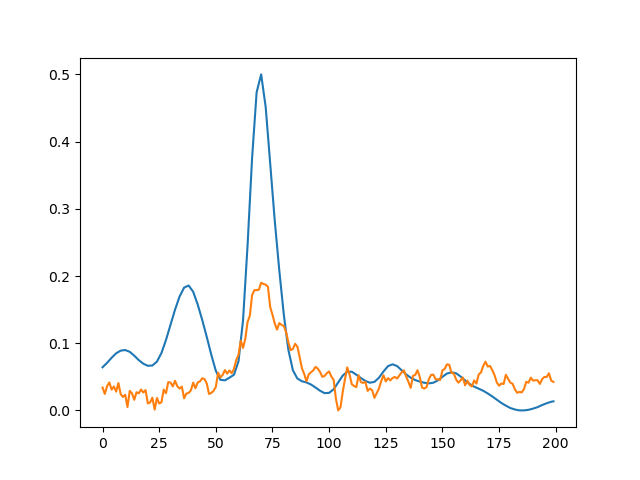

In [411]:
%matplotlib widget
from sklearn import preprocessing

def get_rsquared(y, ypred):
    ss_res   = np.sum(np.square(y-ypred))
    ss_total = np.sum(np.square(y-np.mean(y)))
    
    r_squared = 1 - ss_res/ss_total
    return r_squared

### specifications
feature_range           = (0,0.5)
fit_start, fit_end  = (1.55, 1.85)
scaling_start, scaling_end = (1, 2)
seek_mf = (0.1, 0.9, 0.02)

### reshaping and interpolating simulated and experimental data
simulated_data = np.array(simulated)
simulated_data = np.interp(qgrid2, qvalues, simulated_data)

### experimental data
exp_data = data.IqBsTs.T

### Preprocessing simulated and experimental data
idxSS, idxSE = qgrid_to_indices(qgrid2, scaling_start) , qgrid_to_indices(qgrid2, scaling_end)
idxFS, idxFE = qgrid_to_indices(qgrid2[idxSS:idxSE], fit_start) , qgrid_to_indices(qgrid2[idxSS:idxSE], fit_end)
scaler = preprocessing.MinMaxScaler(feature_range=feature_range)
sc_simulated_data = scaler.fit_transform(simulated_data[idxSS:idxSE].reshape(-1,1))[...,0]
sc_exp_data = scaler.fit_transform(exp_data[idxSS:idxSE].reshape(-1,1))[...,0]

### fitting exp_data and simulated_data
ll, ul, inc =seek_mf
mul_factor = np.arange(ll, ul, inc)                                  # scaling factor lookup region

err = {}; err['MF'] = np.zeros(len(mul_factor)); err['R2'] = np.zeros(len(mul_factor))
for idx, mf in enumerate(mul_factor):
    err['MF'][idx] = mf
    err['R2'][idx] = get_rsquared(sc_simulated_data[idxFS:idxFE], mf*sc_exp_data[idxFS:idxFE])
    
minIdx = err['R2'].argmax()                                         # mf is determined by minimum MSE
mf = round(err['MF'][minIdx],4)
print('mf :', mf)

plt.close('all')
plt.figure()
plt.plot(sc_simulated_data)
plt.plot(mf*sc_exp_data)
# plt.plot(30*exp_data[idxSS:idxSE])

In [406]:
### exp_data

area_minQ, area_maxQ = area_q.value
data   = Data_Analysis(file, qgrid2, window_size=4, directory=os.getcwd())
Iq              = data.bkg_sub(bkg_frame = [379], bkg_file=bkg_file, bkg_dir= bkg_dir)
mf,area         = data.tissue_sub(295, [1593], mf_Qindices = fit_q_range.value, method = 'MSE', area_minQ= area_minQ, area_maxQ = area_maxQ,  seek_mf = seek_mf, show_result=True)

(1681, 690) None None
MF =  1.33 AREA: 1.0~1.45 =  0.00023383956685601125


In [408]:
simulated = [1.17e+09, 1.09e+09, 8.80e+08, 6.25e+08, 4.03e+08, 2.46e+08,
       1.48e+08, 8.64e+07, 4.59e+07, 2.15e+07, 9.79e+06, 5.80e+06,
       4.89e+06, 4.86e+06, 5.22e+06, 5.61e+06, 5.51e+06, 4.82e+06,
       3.89e+06, 3.08e+06, 2.44e+06, 1.92e+06, 1.53e+06, 1.29e+06,
       1.13e+06, 9.92e+05, 8.39e+05, 7.15e+05, 6.54e+05, 6.53e+05,
       6.93e+05, 7.59e+05, 8.32e+05, 8.84e+05, 8.86e+05, 8.30e+05,
       7.34e+05, 6.27e+05, 5.27e+05, 4.44e+05, 3.78e+05, 3.34e+05,
       3.07e+05, 2.93e+05, 2.85e+05, 2.85e+05, 2.93e+05, 3.05e+05,
       3.09e+05, 3.05e+05, 2.94e+05, 2.79e+05, 2.61e+05, 2.41e+05,
       2.23e+05, 2.11e+05, 2.08e+05, 2.16e+05, 2.39e+05, 2.83e+05,
       3.49e+05, 4.30e+05, 5.19e+05, 6.04e+05, 6.77e+05, 7.26e+05,
       7.43e+05, 7.28e+05, 6.84e+05, 6.18e+05, 5.37e+05, 4.50e+05,
       3.67e+05, 2.96e+05, 2.43e+05, 2.10e+05, 1.96e+05, 1.97e+05,
       2.08e+05, 2.19e+05, 2.24e+05, 2.23e+05, 2.17e+05, 2.09e+05,
       2.02e+05, 2.00e+05, 2.08e+05, 2.26e+05, 2.50e+05, 2.78e+05,
       3.05e+05, 3.29e+05, 3.43e+05, 3.45e+05, 3.35e+05, 3.16e+05,
       2.93e+05, 2.70e+05, 2.54e+05, 2.49e+05, 2.55e+05, 2.70e+05,
       2.87e+05, 3.02e+05, 3.11e+05, 3.13e+05, 3.07e+05, 2.94e+05,
       2.79e+05, 2.67e+05, 2.60e+05, 2.61e+05, 2.74e+05, 3.03e+05,
       3.47e+05, 3.98e+05, 4.49e+05, 4.93e+05, 5.23e+05, 5.30e+05,
       5.09e+05, 4.66e+05, 4.14e+05, 3.57e+05, 2.97e+05, 2.43e+05,
       2.13e+05, 2.11e+05, 2.20e+05, 2.30e+05, 2.75e+05, 4.13e+05,
       6.65e+05, 9.59e+05, 1.18e+06, 1.24e+06, 1.13e+06, 9.38e+05,
       7.48e+05, 5.81e+05, 4.32e+05, 3.14e+05, 2.45e+05, 2.17e+05,
       2.08e+05, 2.04e+05, 1.97e+05, 1.87e+05, 1.76e+05, 1.68e+05,
       1.69e+05, 1.81e+05, 2.04e+05, 2.27e+05, 2.40e+05, 2.40e+05,
       2.30e+05, 2.19e+05, 2.09e+05, 2.03e+05, 2.06e+05, 2.20e+05,
       2.41e+05, 2.59e+05, 2.65e+05, 2.59e+05, 2.45e+05, 2.31e+05,
       2.20e+05, 2.12e+05, 2.07e+05, 2.03e+05, 2.01e+05, 2.03e+05,
       2.11e+05, 2.23e+05, 2.34e+05, 2.38e+05, 2.35e+05, 2.24e+05,
       2.11e+05, 1.99e+05, 1.90e+05, 1.83e+05, 1.76e+05, 1.67e+05,
       1.57e+05, 1.46e+05, 1.35e+05, 1.26e+05, 1.18e+05, 1.13e+05,
       1.10e+05, 1.10e+05, 1.12e+05, 1.16e+05, 1.21e+05, 1.28e+05,
       1.34e+05, 1.39e+05, 1.42e+05]

In [61]:
### Averaging background frames
%matplotlib widget
import glob, ast

Excel_File  = "/Users/bashit.a/Documents/Alzheimer/Mar-2023/Mar-2023-Samples-updated.xlsx"  
column_names = {"Diffuse_Plaque":1., "Tau":0., "Tau_Dentate_Cells":2}
BNL_dir     = '/Volumes/HDD/BNL-Data/Mar-2023' 
sub_dir     = "CSV_Conv-8-point" 
sheet       = 'Mar-2023-Samples'

def get_dataframe_with_files_loc(file, sheet, BNL_dir, sub_dir):
    ### read dataframe
    df = pd.read_excel(file, sheet_name=sheet)
    df["File_Loc"] = pd.Series([], dtype=str)
    for idx, file in zip(df.index, df['File']):
        for file_search in glob.iglob(f'{BNL_dir}/**/*', recursive=True):
            if file_search.find(file) > -1 and f'/{sub_dir}/' in file_search:
                df.at[idx, 'File_Loc'] = file_search
                break
    return df



df = get_dataframe_with_files_loc(Excel_File, sheet, BNL_dir, sub_dir)

lidx, uidx = 0, 690


# temp = []
# for _ in Iq_values_bkg:
#     temp += _
# Iq_values_bkg = np.array(temp)
# Iq_bkg_avg = np.mean(Iq_values_bkg, axis=0)

column_name : contains 49 franes
column_name : contains 25 franes
column_name : contains 104 franes


In [5]:
### Load all frames mf, and area data
sc_data = {}; sc_data['mf'] = np.zeros(data.n_patterns); sc_data['area'] = np.zeros(data.n_patterns)
for frame in range(data.n_patterns):
    sc_data['mf'][frame] , sc_data['area'][frame]   =  data.scaling_frame(frame, tissue_frames_sorted[0], mf_Qindices = (QSearchStart, QSearchEnd), seek_mf = seek_mf, window_size=window_size, show_result=False)

Fr- 2264 value:  0.00051472
Fr- 677 value:  0.00049968
Fr- 2953 value:  0.00046261
Fr- 4284 value:  0.00027855
Fr- 5804 value:  0.00024981
Fr- 3906 value:  0.0002411
Fr- 1022 value:  0.0002245
Fr- 3533 value:  0.00022358
Fr- 7309 value:  0.00022298
Fr- 122 value:  0.00022141
Fr- 2526 value:  0.0002182
Fr- 5543 value:  0.0002177
Fr- 2646 value:  0.00021695
Fr- 6292 value:  0.00021587
Fr- 2296 value:  0.00021322
Fr- 6305 value:  0.0002125
Fr- 4400 value:  0.00021054
Fr- 6186 value:  0.00020836
Fr- 7432 value:  0.00020464
Fr- 5050 value:  0.00020318
Fr- 7684 value:  0.00020246
Fr- 6299 value:  0.00020147
Fr- 5909 value:  0.00020054
Fr- 5157 value:  0.00019953
Fr- 261 value:  0.00019929
Fr- 3398 value:  0.00019919
Fr- 1244 value:  0.00019863
Fr- 133 value:  0.00019819
Fr- 5407 value:  0.00019738
Fr- 3646 value:  0.00019682
Fr- 5915 value:  0.00019667
Fr- 2888 value:  0.00019662
Fr- 3020 value:  0.00019641
Fr- 3774 value:  0.00019629
Fr- 6548 value:  0.00019574
Fr- 4276 value:  0.00019566
F

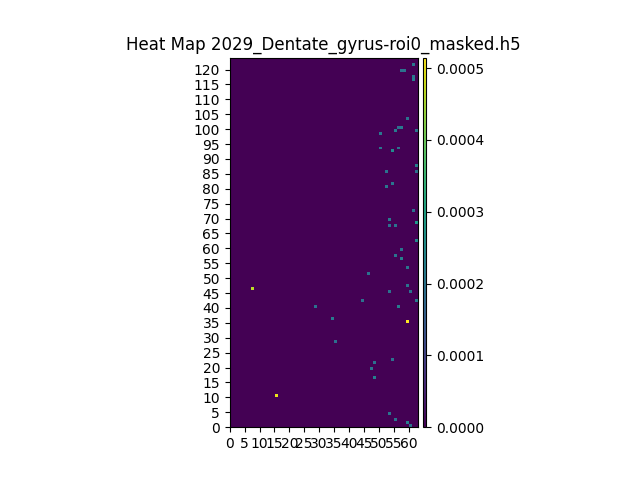

In [6]:
### Draw heat map depending on background subtracted descending area 
%matplotlib widget

file = file
sort_by = sc_data['area']

sorted_idx  = np.argsort(sort_by, kind='stable')[::-1][:50] # sc_data['area'].shape = (4941,)  # first 50 area sorted descending

diff_patterns = np.zeros(len(sort_by))
diff_patterns[sorted_idx] = sort_by[sorted_idx]
Width, Height = width_height(file)
img_orig = snaking(Width, Height, diff_patterns)

f,ax = plt.subplots()
plot_heat_map_from_data(img_orig, Width, Height, args = (f, ax), title= f'Heat Map {file}')
[print('Fr-',idx, 'value: ' , np.round(diff_patterns[idx],8)) for idx in sorted_idx]
pass

[2264  677 2953 4284 5804 3906 1022 3533 7309  122 2526 5543 2646 6292
 2296 6305 4400 6186 7432 5050 7684 6299 5909 5157  261 3398 1244  133
 5407 3646 5915 2888 3020 3774 6548 4276 2895 7555 7554 4274 3259 1394
 2664 5417 2554 4537 1371    2 6306 1791]


interactive(children=(Dropdown(description='Frame:', options=(2264, 677, 2953, 4284, 5804, 3906, 1022, 3533, 7…

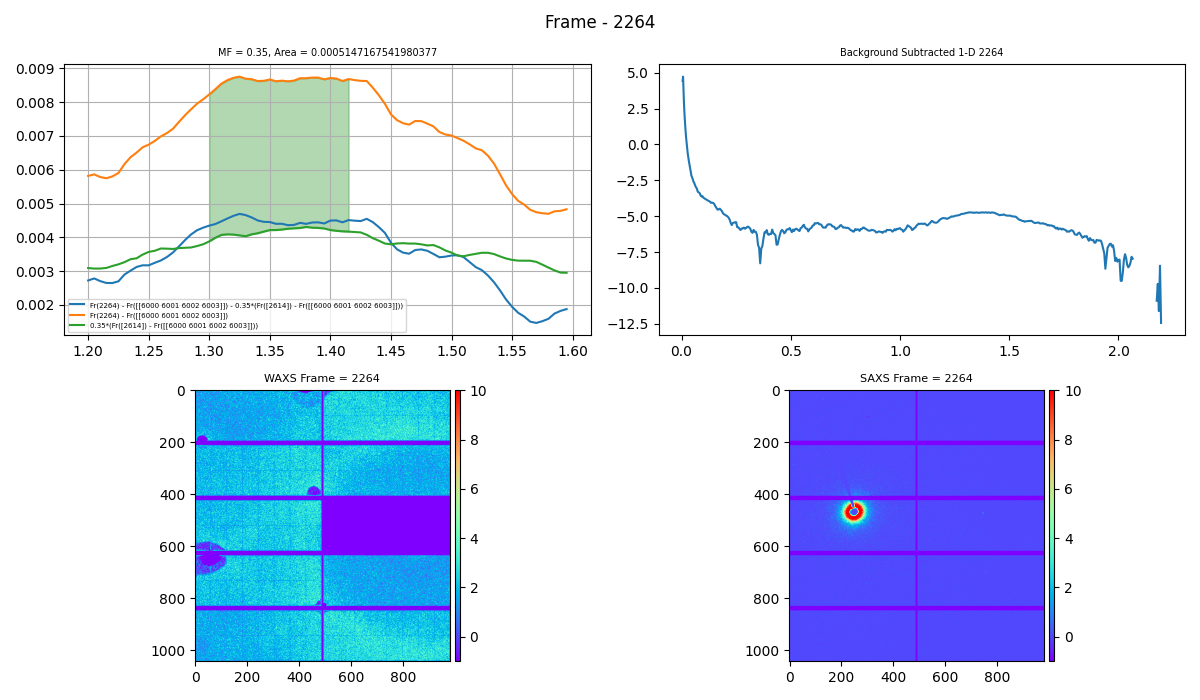

In [8]:
#### check generated heat maps collected frame data
%matplotlib widget
def exec_dropdown_value(frame):
    
    mf,area =  data.scaling_frame(frame, tissue_frame, mf_Qindices = (QSearchStart, QSearchEnd), seek_mf = seek_mf, window_size=window_size, show_result=True)
    data.plot()
    
frame = ipywidgets.Dropdown(options= sorted_idx,  description='Frame:',    disabled=False, continuous_update=False)
out = ipywidgets.interactive(exec_dropdown_value, frame=frame)
print(sorted_idx)
display(out)

qvalue is : 0.0150
Minimum, Maximum Iq : -7.8976, 25.0031
qvalue is : 1.3450
Minimum, Maximum Iq : -0.0048, 0.0248


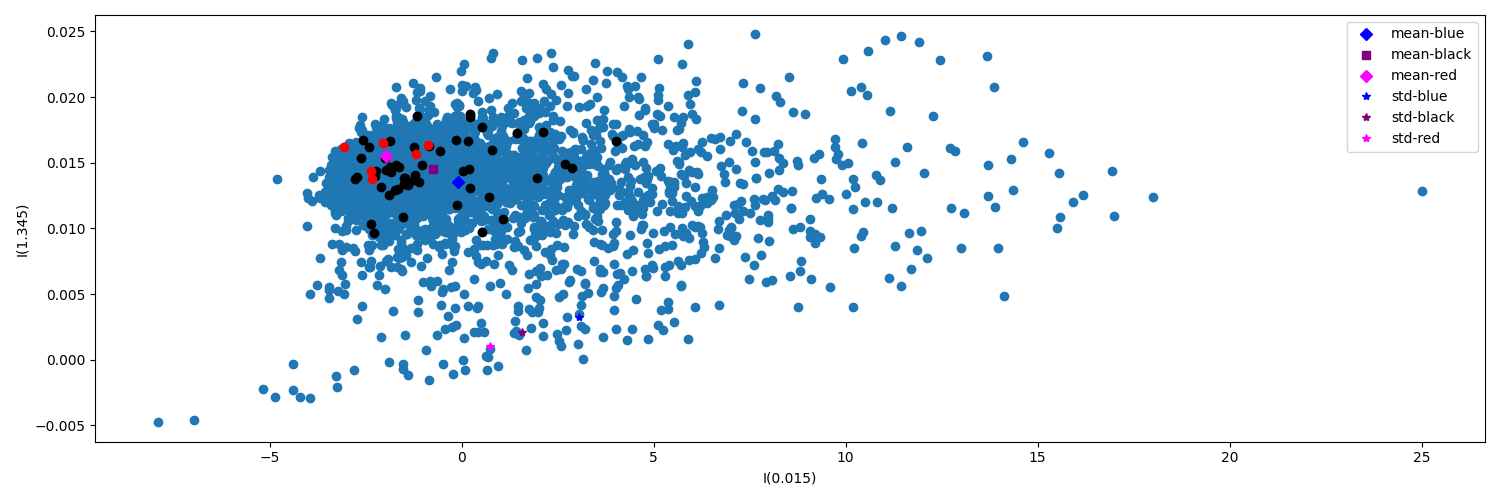

In [30]:
### Iq(1.345) vs Iq(0.015) plot -- requires previous cell to run first
%matplotlib widget

file =  '2410_EC-roi1_masked.h5' # '2048_B8_masked.h5' # '2109_EC-roi0_masked.h5' # '1892_EC-roi0_masked.h5' # '2512_EC-roi1_masked.h5' # '2029_Dentate_gyrus-roi0.h5'    # '2029_EC-roi0.h5'    '2029_Dentate_gyrus-roi0_masked.h5'  '2048_B8_masked.h5'
data = Data_Analysis(file, qgrid2, window_size=window_size, normalize=False, directory=os.getcwd())
Iq   = data.bkg_sub(bkg_frame = bkg_frame)


frames = [3305, 3306, 3267, 3266, 3265, 3264, 3180, 3181, 
2513, 2512, 2511, 2446, 2447, 2448, 2389, 2388, 
770, 769, 717, 718, 647, 646, 645, 592, 593, 
399, 398, 397, 343, 344, 345, 346, 274, 275, 276, 220, 
2259, 2258, 2330, 2331, 2381, 2454, 2505, 2578, 
1604, 1605, 1494, 1995, 1480, 1481, 1371, 1370]

frames2 = [2714, 2742, 2713, 2595, 2593, 2594]
q_point_x = 0.015
q_point_y = 1.345

diff_patterns_x = find_rep_value(qgrid2, Iq , args=q_point_x, method = 'point')
diff_patterns_y = find_rep_value(qgrid2, Iq , args=q_point_y, method = 'point')

f,ax = plt.subplots(nrows=1, ncols=1,figsize=(15,5))
ax.plot(diff_patterns_x,diff_patterns_y,'o')
ax.plot(diff_patterns_x[frames,] , diff_patterns_y[frames,],   'o', color='black')
ax.plot(diff_patterns_x[frames2,] , diff_patterns_y[frames2,], 'o', color='red')
ax.plot(np.mean(diff_patterns_x), np.mean(diff_patterns_y), 'D', color='blue', label='mean-blue')
ax.plot(np.mean(diff_patterns_x[frames]), np.mean(diff_patterns_y[frames]), 's', color='purple', label='mean-black')
ax.plot(np.mean(diff_patterns_x[frames2]), np.mean(diff_patterns_y[frames2]), 'D', color='magenta', label='mean-red')
ax.plot(np.std(diff_patterns_x), np.std(diff_patterns_y),                    '*', color='blue', label='std-blue')
ax.plot(np.std(diff_patterns_x[frames]), np.std(diff_patterns_y[frames]),    '*', color='purple', label='std-black')
ax.plot(np.std(diff_patterns_x[frames2]), np.std(diff_patterns_y[frames2]),  '*', color='magenta', label='std-red')
ax.set(xlabel = f'I({q_point_x})', ylabel = f'I({q_point_y})')
ax.legend()

plt.tight_layout()

Python directory is set to load samples from : Mar-2023-Sample#1898
(1681, 690) None None
no tissue found for frame -  14  ; thus dropping this frame -> []
no tissue found for frame -  56  ; thus dropping this frame -> []
no tissue found for frame -  57  ; thus dropping this frame -> []
no tissue found for frame -  58  ; thus dropping this frame -> []
no tissue found for frame -  59  ; thus dropping this frame -> []
no tissue found for frame -  60  ; thus dropping this frame -> []
no tissue found for frame -  61  ; thus dropping this frame -> []
no tissue found for frame -  62  ; thus dropping this frame -> []
no tissue found for frame -  63  ; thus dropping this frame -> []
no tissue found for frame -  87  ; thus dropping this frame -> []
no tissue found for frame -  122  ; thus dropping this frame -> []
no tissue found for frame -  134  ; thus dropping this frame -> []
no tissue found for frame -  201  ; thus dropping this frame -> []
no tissue found for frame -  205  ; thus dropping

interactive(children=(SelectionSlider(description='index', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

interactive(children=(Button(description='Save Plot', style=ButtonStyle()), Output()), _dom_classes=('widget-i…

csv file generated in  /Volumes/HDD/BNL-Data/Mar-2023/1898
    plaque-frame       tissue-frames  \
0             17     [143, 144, 145]   
1             51     [197, 196, 195]   
2            129     [283, 282, 281]   
3            139     [273, 272, 271]   
4            295     [445, 444, 443]   
5            296     [444, 443, 442]   
6            359     [457, 458, 459]   
7            361     [455, 456, 457]   
8            382     [522, 521, 520]   
9            825     [975, 976, 977]   
10           905  [1059, 1060, 1061]   
11           923  [1041, 1042, 1043]   
12           980  [1072, 1071, 1070]   
13          1032  [1184, 1183, 1182]   
14          1093  [1199, 1200, 1201]   
15          1417  [1531, 1532, 1533]   
16          1664  [1667, 1666, 1665]   

                                                                                                                                                                                                                            

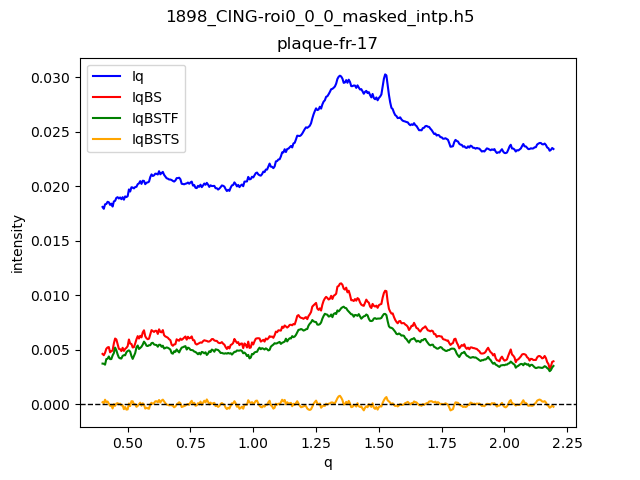

In [23]:
### find heatmap using (I_p - I_avg) -- MultiThreating Processing
%matplotlib widget
import concurrent.futures
from matplotlib import colors

start = time.perf_counter()

### directory locaito
default_sample_dir =  'Mar-2023-Sample#1898'  #  'Mar-2023-Misc'    #'July-sorted'  # '20-Dec' # 'July-2021-Sample#6'   'Mar-2023-Sample#1898'
csv_and_code_abs_directory = '/Users/bashit.a/Documents/Alzheimer/Codes/'
samples_csv = 'data_directory.csv'

_,dropdown_name_list, cwd, exp_folder  = change_python_path(dropdown_name = default_sample_dir, csv_file_location = csv_and_code_abs_directory, samples_csv = samples_csv)

#### specs - plaques search
file =  "1898_CING-roi0_0_0_masked_intp.h5"   # '2048_B8_masked.h5' # '2109_EC-roi0_masked.h5' # '1892_EC-roi0_masked.h5' # '2512_EC-roi1_masked.h5' # '2029_Dentate_gyrus-roi0.h5'    # '2029_EC-roi0.h5'    '2029_Dentate_gyrus-roi0_masked.h5'  '2048_B8_masked.h5'
bkg_frame                  = [379] # [7045,7046] # 973       # background frame  '2109_EC-roi1_masked.h5'-->  [3460, 3461]   '2029_Dentate_gyrus-roi0.h5' --> [7000, 7001]  2410_EC-roi1_masked.h5 --> [2641, 2642]

window_size    = 4     # 4 point averaging
peak_q         = 1.33  ########### Think this required ??????
# Ipeak at q
first_avg_q    = 1.23  # left q from Ipeak to be averaged
second_avg_q   = 1.43  # right q from Ipeak to be averaged
n_calc_frames  = 100   # get the highest 500 frames
opening_kernel = 2     # 2x2 kernel for morphological operation
n_tissue_frms  = 3     # kernal outputs best 3 potential tissue frames
mf_max = 2.5           # mf must be less than this value
mf_min = 1.0           # mf must be greater than this value

#### specs - tissues search
QSearchStart, QSearchEnd   = 1.55, 1.85                      # scaling regions 295,310 or may be 290,370    1.55, 1.8 
seek_mf                    = (-12,12,0.01)                  # mf goes from -8 to +8 by 0.01
kernal_size                = 7;                             # kernal 7 - 48 frames surrounded by plaque frame
area_minQ = 1.0                                             # min area to search q
area_maxQ = 1.45                                            # max area to search q
start, end = 130, 490                                       # ipywidget plot and classifer
# tissue_frs_find_alg = --->>> 'one-fr-one-cluster'   'all-frs-one-cluster' [2067, 2068]
tissue_frs_find_alg = [14, 17, 51, 56, 57, 58, 59, 60, 61, 62, 63, 87, 122, 129, 134, 139, 201, 205, 233, 276, 294, 295, 296, 300, 321, 342, 353, 359, 361, 362, 363, 375, 377, 378, 379, 380, 382, 444, 479, 503, 524, 525, 526, 647, 690, 697, 713, 723, 727, 761, 816, 819, 825, 845, 875, 898, 899, 905, 923, 980, 1003, 1032, 1045, 1046, 1047, 1071, 1090, 1091, 1093, 1125, 1148, 1170, 1205, 1293, 1305, 1324, 1342, 1361, 1364, 1417, 1442, 1479, 1520, 1636, 1664] ## plaque frames
save_fr_csv = False                                          # each tissue_frs_find_alg will create one csv

### make a color map of fixed colors
# cmap = 'tab10'  # discrete_cmap(N=3, base_cmap = 'tab10')
cmap = colors.ListedColormap(['darkblue', 'green' ,'red'])
bounds=[0, 126, 250, 255]
norm = colors.BoundaryNorm(bounds, cmap.N)

### computations

### pandas setting to ignore warning
pd.options.display.max_columns  = None
pd.options.display.max_rows     = None
pd.options.display.max_colwidth = None
pd.options.mode.chained_assignment = None  # default='warn'

### Ipeak - (Iq1+Iq2)/2 calcuations for potential frames
data   = Data_Analysis(file, qgrid2, window_size=window_size, directory=os.getcwd())

Iq   = data.bkg_sub(bkg_frame = bkg_frame)
npatterns = Iq.shape[0]
Width, Height = width_height(file)
sna = snaking(Width, Height)

if tissue_frs_find_alg == 'one-fr-one-cluster' or tissue_frs_find_alg == 'all-frs-one-cluster' :
    
    ### sorting frames by intensity differeces
    result = {}; result['diff'] = np.zeros(npatterns) # result['diff'].shape - (7812,)
    for frame in range(npatterns):
        result['diff'][frame] = Iq[frame, qgrid_to_indices(qgrid2, peak_q)] - (Iq[frame, qgrid_to_indices(qgrid2, first_avg_q)]+Iq[frame, qgrid_to_indices(qgrid2, second_avg_q)])/2
    potential_plaques = np.argsort(result['diff'],axis= None, kind='stable')[::-1][:n_calc_frames]

    print(np.sort(potential_plaques))
    
    ### morpholocal operations
    A_MAT = np.array([np.zeros((Height,Width)),sna])   # zero values matrix (A[0]=0) with frame numbers depth (A[1]=frames)
    A = from_clusterFr_ceffs_to_matrix(A_MAT, potential_plaques, np.ones(len(potential_plaques)))
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(17,6))
    plot_heat_map_from_data(A[0], Width, Height, args = (fig, ax1), title= f'original - frames-{n_calc_frames}', cmap=cmap)
    mask,_ = global_thresholding(A[0], thr=1, binary_inv = False)
    _, mask = cv2.threshold(A[0], 0, 255, cv2.THRESH_BINARY)
    kernal = np.ones((opening_kernel,opening_kernel), np.uint8)
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernal)

    ### clustering variable declarations
    labeled_array, num_features = label(opening, np.ones((3,3)))
    print('Total clusters = ', num_features)
    
    #### get clusters --> len(clusters)=175
    clusters = []
    cluster_label = []
    for i in np.arange(1,num_features+1,1):  # zero label is for background, rest labels are for clusters
        _ = sna[labeled_array==i]
        clusters.append(_.tolist())
        cluster_label.append(len(_)*[i])
    clusters = flatten(clusters)
    cluster_label = flatten(cluster_label)

    ### dataframe creation
    df = pd.DataFrame(columns=['plaque-frame', 'cluster-label' ,'selected-plaque', \
                               'tissue-frames', 'tissue-frames-all', 'tissue-frames-mf', 'tissue-frames-area', \
                               'IqBSTF', 'IqBSTS'], index=np.arange(0,len(clusters),1))
    df['plaque-frame']  = clusters
    df['cluster-label'] = cluster_label

    ### find the representative frame from each cluster
    df['selected-plaque'] = False                           # initilizing to False
    for i in np.arange(1, num_features+1,1):
        cluster_frames = df['plaque-frame'][df['cluster-label']==i].values   # frames in each cluster
        cluster_max_frame = cluster_frames[np.argmax(result['diff'][cluster_frames])]
        df.loc[df.index[df['plaque-frame'] == cluster_max_frame],'selected-plaque'] = True # True only if the frame is the maximum in a cluster
    # print(df.loc[df.index[df['selected-plaque']==True], 'plaque-frame'])

else:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17,6))
    ax2 = ax
    ax3 = ax

    df = pd.DataFrame(columns=['plaque-frame', 'tissue-frames', 'tissue-frames-all', 'tissue-frames-mf', 'tissue-frames-area', \
                           'IqBSTF', 'IqBSTS'], index=np.arange(0,len(tissue_frs_find_alg),1))
    df['plaque-frame'] = tissue_frs_find_alg
    
### kernal sliding and getting background frames
fr_idx = Snaking_frames_search(Width, Height)   # kernal frame search class

# def kernal_mp(idx, frame):                                  #### uncomment to parallelize
# frames_to_look_for 
for idx, frame in enumerate(df["plaque-frame"].values):       #### comment out to parallelize

    if tissue_frs_find_alg == 'one-fr-one-cluster' and df['selected-plaque'][idx] == False:
        continue;
    elif tissue_frs_find_alg == 'all-frs-one-cluster':
        pass;

    ### kernal sliding and getting tissue frames
    tissue_frames = np.array(fr_idx.frame_idx_to_kernal_frames(kernal_size, frame))  # kernal tissue frames

    ### declare variable
    mf   = np.full(npatterns,np.nan);   # do not trust mf - nearby mf (two cluster same frame) is overwritten
    area = np.full(npatterns,np.nan);   # do not trust area - nearby area (two cluster same frame) is overwritten

    ### get tissues
    area_temp = np.zeros(len(tissue_frames))
    for i,tissue_frame in enumerate(tissue_frames):
        mf[tissue_frame], area_temp[i] = data.tissue_sub(frame, tissue_frames, mf_Qindices = (QSearchStart, QSearchEnd), method = 'MSE', area_minQ= area_minQ, area_maxQ = area_maxQ,  seek_mf = seek_mf, show_result=False)
        area[tissue_frame] = area_temp[i]

    tissue_frames_sorted = tissue_frames[np.argsort(area_temp, axis= None, kind='stable')[::-1] ] # descending order
    tissue_pot = []
    for pot_tissue in tissue_frames_sorted :
        if mf[pot_tissue] <mf_max and mf[pot_tissue] > mf_min :
            tissue_pot.append(pot_tissue)
        if len(tissue_pot)==n_tissue_frms:
            break
    if len(tissue_pot) == 0:
        print('no tissue found for frame - ',frame, ' ; thus dropping this frame ->', np.array(tissue_pot))
        df.drop(index=idx, inplace=True)
        continue;
    df['tissue-frames-all'][idx]  = tissue_frames_sorted.tolist()
    df['tissue-frames'][idx]      = np.array(tissue_pot).tolist()  
    df['tissue-frames-mf'][idx]   = [mf[tissue_frame]   for tissue_frame in df['tissue-frames'][idx]]
    df['tissue-frames-area'][idx] = [area[tissue_frame] for tissue_frame in df['tissue-frames'][idx]]
    df['IqBSTF'][idx], df['IqBSTS'][idx] = data.scaling_by, data. IqBsTs
    df['IqBSTS'][idx] = df['IqBSTS'][idx].flatten().tolist()
    df['IqBSTF'][idx] = df['IqBSTF'][idx].flatten().tolist()

#### uncomment to parallelize
# with concurrent.futures.ThreadPoolExecutor(max_workers=None) as executor:
#     results = executor.map(kernal_mp, np.arange(len(df["plaque-frame"].values)), df["plaque-frame"].values)

### resetting indices as some frames might have dropped
df.reset_index(drop=True,inplace=True)  # drop parameter to avoid the old index being added as a column

### plot truncated tissues on top of opening images - (clustering results same as opening)
A_MAT = np.array([np.full((Height,Width),0),sna])   # zero values matrix (A[0]=0) with frame numbers depth (A[1]=frames)
B = from_clusterFr_ceffs_to_matrix(A_MAT, cluster=df['plaque-frame'], coeffs=np.full_like(df['plaque-frame'], 255, dtype=int))           # set all plaque to 255
plot_heat_map_from_data(B[0], Width, Height, args = (fig, ax2), title= f'clustered total frames-{len(df["plaque-frame"])}', cmap=cmap)

tissues = [i for i in df['tissue-frames'] if np.any(np.isnan(i)) == False]  ### for selctive case run only NOT nan frames
tissues = np.unique(flatten(tissues))
A_MAT = np.array([np.zeros((Height,Width)),sna])   # zero values matrix (A[0]=0) with frame numbers depth (A[1]=frames)
C = from_clusterFr_ceffs_to_matrix(A_MAT, cluster= tissues, coeffs=np.full_like(tissues, 127, dtype=int))
plot_heat_map_from_data(np.clip(B[0]+C[0],0,255), Width, Height, args = (fig, ax3), title= f'norm. and peak find at q{peak_q}', cmap=cmap, norm=norm, ticks = [0, 127, 255])



#### Scroll through frames
from sklearn.preprocessing import StandardScaler

# ### X array-like of shape (n_samples, n_features)
# X = np.zeros((len(df), len(qgrid2)))
# for idx in range(len(df)):
#     X[idx,:] = df['IqBSTF'][idx]
# X = StandardScaler().fit_transform(X)  # Standard Scalar
# X = X[:,start:end]                     # X is what you see on plt

### ipywidget plot
# plt.close('all')

plt.close('all')
plt.figure(num=file)
plt.suptitle(file)
plt.tight_layout()
def plaque_bkg_plots(index):
    plaque = df['plaque-frame'].loc[index]
    plt.cla()
    plt.plot(data.qgrid[start:end], data.Iq[plaque][start:end]        ,   color= 'blue',        label = 'Iq' )
    plt.plot(data.qgrid[start:end], data.IqBS[plaque][start:end]      ,   color= 'red',        label = 'IqBS'  )
    plt.plot(data.qgrid[start:end], df['IqBSTF'].loc[index][start:end],  color= 'green',      label = 'IqBSTF')
    plt.plot(data.qgrid[start:end], df['IqBSTS'].loc[index][start:end],  color= 'orange',        label = 'IqBSTS')
    plt.legend()
    plt.axhline(y=0, color='black', linewidth=1.0 ,linestyle='--')
    plt.xlabel('q')
    plt.ylabel('intensity')
    
    if save_fr_csv:
        df_index= pd.DataFrame({'qgrid':data.qgrid[start:end], 'Iq':data.Iq[plaque][start:end], 'IqBS':data.IqBS[plaque][start:end], 'IqBSTF': df['IqBSTF'].loc[index][start:end], 'IqBSTS': df['IqBSTS'].loc[index][start:end]})
        df_index.to_csv(f'{file}-{plaque}.csv')
    else:
        pass
    
    if tissue_frs_find_alg == 'one-fr-one-cluster' or tissue_frs_find_alg == 'all-frs-one-cluster' :
        plt.title(f'plaque-fr-{plaque}, group-{df["cluster-label"][index]}, index:{index}')
    else:
        plt.title(f'plaque-fr-{plaque}')

    #plt.axis([None,None,None,0.12*10**6])

def save_plot():
    plt.savefig(f'{file}-fr{df["plaque-frame"].loc[index.value]}.tif', bbox_inches='tight', dpi=300) # Saving the image as an eps file

if tissue_frs_find_alg == 'one-fr-one-cluster' :
    scroll_frames = df.index[df['selected-plaque'] == True]   # df.index[df['selected-plaque'] == True]    # df.index.values
elif tissue_frs_find_alg == 'all-frs-one-cluster' :
    scroll_frames = df.index.values   # df.index[df['selected-plaque'] == True]    # df.index.values
else:
    scroll_frames = df.index.values   # df.index[df['selected-plaque'] == True]    # df.index.values

index = ipywidgets.SelectionSlider(value = scroll_frames[0], options = scroll_frames)
ipywidgets.interact(plaque_bkg_plots, index=index)
ipywidgets.interact_manual.opts['manual_name'] = 'Save Plot'
ipywidgets.interact_manual(save_plot)

### create csv file
print('csv file generated in ',os.getcwd())
df.to_csv('result.csv')
print(df.iloc[:,:4])        #### display dataframe

finish = time.perf_counter();    print(f'finished in {(finish-start)//60} minutes and {(finish-start)%60} seconds')

In [32]:
%matplotlib widget
import mplcursors
from matplotlib.widgets import CheckButtons

from essential_func import *
from ipywidgets import Layout, Button, Box, BoundedIntText, IntText, FloatText, Textarea, Dropdown, Label, FloatSlider, IntSlider, Checkbox

### updating list
def get_files_list(dropdown_name , seek_strs = ['.h5','.csv', '.xlsx']):
    df  = pd.read_csv(os.path.join(csv_and_code_abs_directory,samples_csv))
    idx = df[df["dropdown-name"]==dropdown_name].index
    directory = df['bnl-scan-sample-dir'][idx].values[0]
    files_list = []
    for seek_str in seek_strs:
#         print(seek_strs)
        files_list.append(cwd_files_search_with(seek_str, directory = directory, ))
#     print(flatten(files_list))
    return directory, flatten(files_list)

### general layout
form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between'
)
### main menu widgets
bkg_sub   = Checkbox(value = False)
normalize = Dropdown(options=['min-max', 'No'], value = 'min-max')
n_filt    = BoundedIntText(value =4, min=1, max=20, style = {'description_width': 'initial'})
y_axis    = Dropdown(options=['Iq', 'log(Iq)', 'qlog(Iq)'])
x_axis    = Dropdown(options=['q', 'q^2'])
fr_cat    = BoundedIntText(value =1, min=1, max=10, style = {'description_width': 'initial'}, description = 'No. of Frames Category ' , layout=form_item_layout)

main_menu = Box(
    [
    Box([Label(value='Background Subtraction '),bkg_sub], layout=form_item_layout),
    Box([Label(value='Normalize '),  normalize], layout=form_item_layout), 
    Box([Label(value='N-point Filt. '), n_filt], layout=form_item_layout), 
    Box([Label(value='Y-axis. '),       y_axis], layout=form_item_layout), 
    Box([Label(value='X-axis. '),       x_axis], layout=form_item_layout),
    ], 
    layout= Layout(
        display='flex',
        flex_flow='column',
        border='solid 2px',
        align_items='stretch',
        width='30%')
    )
### create dynamic function name
def bindFunction(name):
    def func_(*args):
        file[name].options = get_files_list(dropdown_name = directory[name].value)[1]
    func_.__name__ = 'on_value_change_'+str(name)
    return func_

def create_form_items(total_categories, bkg_subtraction):
    ## form widgets
    global directory, file, bkg_fr, frames, form_items, idx_
    directory = {}; file = {}; bkg_fr={}; frames={}; form_items = []
    for i in range(total_categories):
        directory[i] = Dropdown(options = dropdown_name_list)
        file[i]      = Dropdown(options = get_files_list(dropdown_name = dropdown_name_list[0] , seek_strs = ['.h5','.csv', '.xlsx'])[1])
        bkg_fr[i]    = IntText() if bkg_subtraction else IntText(value = 55555, disabled=True)   ### default back_sub frame means bkg_sub is false
        frames[i]    = Textarea()
        
        directory[i].observe(bindFunction(i), names='value')
        
        form_items.append([
                Box([Label(value='Directory'),        directory[i]],  layout=form_item_layout),
                Box([Label(value='File'),             file[i]],       layout=form_item_layout),
                Box([Label(value='Background Frame'), bkg_fr[i]],     layout=form_item_layout),
                Box([Label(value='Frames'),           frames[i]],     layout=form_item_layout)
                ]) #* total_categories

    form = Box(flatten(form_items),
    layout=Layout(
        display='flex',
        flex_flow='column',
        border='solid 1px',
        align_items='stretch',
        width='35%')
    )
    display(main_menu, form)

    
def on_button_clicked(*args):
#     if bkg_sub.value == False:
#         saxs_plots, waxs_plots = get_plots(directories = ['/Users/bashit.a/Documents/Alzheimer/July-2021/BNL-Data/sample-6/', \
#                                                          '/Users/bashit.a/Documents/Alzheimer/July-2021/BNL-Data/sample-1/'], \
#                                            files=['2029_Dentate_gyrus-roi0_masked.h5', '2040_FC-roi0.h5'], \
#                                            qgrid=qgrid2, normalize = True, \
#                                            frames = [[6558,981],[150,120]],  x_axis='q' , y_axis='Iq', bkg_fr = [1480, 100 ])
    
    global directories_arg, files_arg, frames_arg, bkg_fr_arg
    directories_arg = []; files_arg=[]; frames_arg = []; bkg_fr_arg = [];

    for idx in range(fr_cat.value):
        directories_arg.append(get_files_list(dropdown_name = directory[idx].value)[0])
        files_arg.append(file[idx].value)
        frames_arg.append([int(i) for i in frames[idx].value.split(",") if i!=''])
        bkg_fr_arg.append(bkg_fr[idx].value)
    print(directories_arg, files_arg, frames_arg, bkg_fr_arg)
                               
button     = ipywidgets.Button(description='Go!');                                      
button.style.button_color = "green";
button.on_click(on_button_clicked)

out = ipywidgets.interactive_output(create_form_items, {'total_categories' : fr_cat, 'bkg_subtraction' : bkg_sub})
display(fr_cat, out, button)

BoundedIntText(value=1, description='No. of Frames Category ', layout=Layout(display='flex', flex_flow='row', …

Output()

Button(description='Go!', style=ButtonStyle(button_color='green'))

reading file ...  /Volumes/HDD/BNL-Data/Mar-2023/1898/ 1898_CING-roi0_0_0_masked_intp.h5 [379, 1417, 1430] 55555
(1681, 690) None None


/var/folders/nk/89hkzs1118vd7g7w28qfmn0r0000gq/T/ipykernel_85104/3329812286.py:100: MatplotlibDeprecationWarning: The rectangles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Any custom property styling may be lost.
  for r,l in zip(check.rectangles, check.lines):
/var/folders/nk/89hkzs1118vd7g7w28qfmn0r0000gq/T/ipykernel_85104/3329812286.py:100: MatplotlibDeprecationWarning: The lines attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Any custom property styling may be lost.
  for r,l in zip(check.rectangles, check.lines):


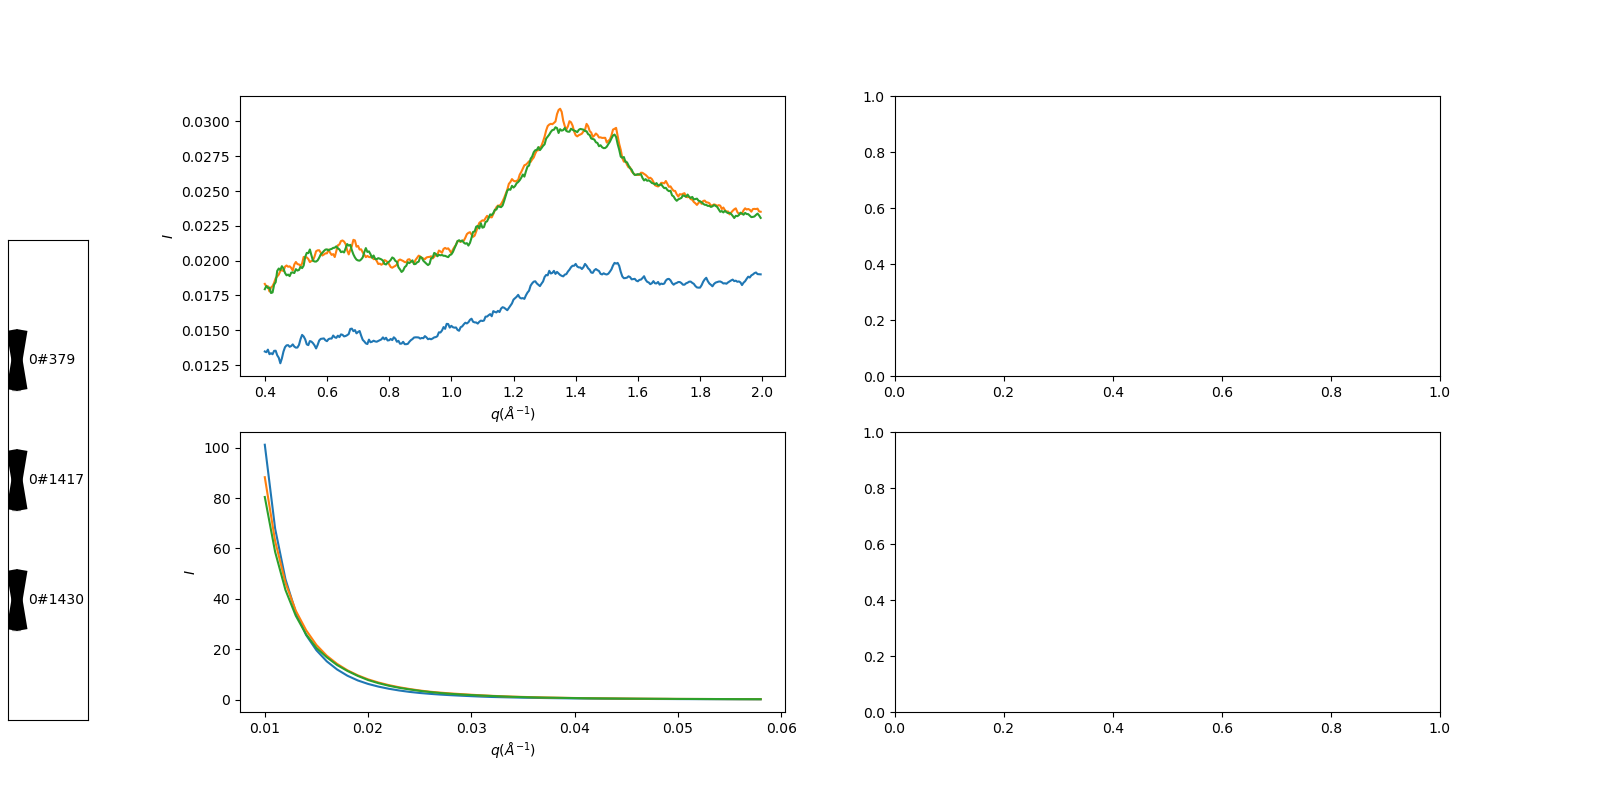

In [33]:
# 1-d plot for high intensities
%matplotlib widget
import mplcursors
from matplotlib.widgets import CheckButtons
import matplotlib.pyplot as plt

# plot
plt.close()
f, ax = plt.subplots(2,2, figsize = (16,8), num=f'data', constrained_layout = False)
plt.subplots_adjust(left=0.15)

def saxs_waxs_plot_data_from_Iq(xData, yData, waxs_idx_start, waxs_idx_end, saxs_idx_start, saxs_idx_end, n_filt, normalize, y_axis):

    if y_axis == 'Iq':
        yData = yData;                          ax[0,0].set_ylabel("$I$");                 ax[1,0].set_ylabel("$I$");
    elif y_axis == 'log(Iq)':
        yData = np.log(yData);             ax[0,0].set_ylabel("$log(I)$");            ax[1,0].set_ylabel("$log(I)$");
    elif y_axis == 'qlog(Iq)':
        yData = np.log(yData*qgrid);      ax[0,0].set_ylabel("$qlog(I)$");           ax[1,0].set_ylabel("$qlog(I)$");
    else:
        print('No yData')

    # filter output using convolution
    ### filter coefficients
    b = np.ones((n_filt))/n_filt    # numerator co-effs of filter transfer function
    a = np.ones(1)                  # denominator co-effs of filter transfer function
    yData = np.convolve(b, yData, mode='same') if n_filt>1 else yData         

    # extract saxs and waxs data
    yData_waxs = yData[waxs_idx_start : waxs_idx_end]
    yData_saxs = yData[saxs_idx_start : saxs_idx_end]

    # normalize saxs and waxs data
    yData_waxs = yData_waxs/np.nanmax(yData_waxs) if normalize=='min-max' else yData_waxs   # normalized by maximum value
    yData_saxs = yData_saxs/np.nanmax(yData_saxs) if normalize=='min-max' else yData_saxs   # normalized by maximum value

    return yData_saxs, yData_waxs

def get_plots(directories, files, qgrid, frames,  x_axis , y_axis, normalize='min-max', n_filt=1, bkg_fr = False,  saxs_scale = 'linear', waxs_scale = 'linear'):
    
    ### specs
    waxs_idx_start     = 130     # qgrid2[130] = 0.4
    waxs_idx_end       = 450     # qgrid2[450] = 2.0
    saxs_idx_start     = 5       # qgrid2[2]   = 0.007
    saxs_idx_end       = 50      # qgrid2[2]   = 0.06
    
    ### create empty lists to return
    saxs_plots = []    
    waxs_plots = []

    xData = qgrid if x_axis == 'q' else np.square(qgrid)

    bkg_fr = [[] for _ in range(len(files))] if bkg_fr==False else bkg_fr

    for idx, (dir_, file_, frame_, bkg_fr_) in enumerate(zip(directories, files, frames, bkg_fr)):    

        try:

            if file_.endswith('csv') or file_.endswith('xlsx'):
                df = pd.read_csv(dir_+file_)
                Iq = np.interp(qgrid, np.array(df['q']), np.array(df['Iq']))   # inpterpolation

                yData_saxs, yData_waxs = saxs_waxs_plot_data_from_Iq(xData, yData = Iq, waxs_idx_start=waxs_idx_start, waxs_idx_end=waxs_idx_end, saxs_idx_start=saxs_idx_start, saxs_idx_end=saxs_idx_end, \
                                                                     n_filt=n_filt, normalize=normalize, y_axis=y_axis,)

                waxs_plots.append(ax[0,0].plot(xData[waxs_idx_start:waxs_idx_end],  yData_waxs, visible=False, label = file_.split(".")[0]))   # here dataset has only one frame
                saxs_plots.append(ax[1,0].plot(xData[saxs_idx_start:saxs_idx_end] , yData_saxs, visible=False, label = file_.split(".")[0]))

            else:
                print('reading file ... ', dir_, file_, frame_, bkg_fr_)
                data = Data_Analysis(file_ , qgrid = qgrid, window_size=1, directory = dir_)

                Iq = data.bkg_sub(bkg_frame = bkg_fr_) if bkg_fr_!=55555 else data.Iq

                for frame in frame_:
                    yData_saxs, yData_waxs = saxs_waxs_plot_data_from_Iq(xData, yData = Iq[frame], waxs_idx_start=waxs_idx_start, waxs_idx_end=waxs_idx_end, saxs_idx_start=saxs_idx_start, saxs_idx_end=saxs_idx_end, \
                                                                     n_filt=n_filt, normalize=normalize, y_axis=y_axis,)

                    waxs_plots.append(ax[0,0].plot(xData[waxs_idx_start:waxs_idx_end],  yData_waxs, visible=True, label = f'{idx}#{frame}'))   # here dataset has only one frame
                    saxs_plots.append(ax[1,0].plot(xData[saxs_idx_start:saxs_idx_end] , yData_saxs, visible=True, label = f'{idx}#{frame}'))
        except:
            print('file reading failed : ', {file_})

    ax[0,0].set(xlabel = "$q (\AA^{-1})$" if x_axis == 'q' else "$q^2 (\AA^{-1})$" , xscale = 'linear', yscale = waxs_scale)
    ax[1,0].set(xlabel = "$q (\AA^{-1})$" if x_axis == 'q' else "$q^2 (\AA^{-1})$" , xscale = 'linear', yscale = saxs_scale)

    return saxs_plots, waxs_plots

### create SAXS WAXS Plot
saxs_plots, waxs_plots = get_plots(directories = directories_arg, files=files_arg, qgrid=qgrid2, normalize=normalize.value, n_filt=n_filt.value, frames = frames_arg,  x_axis=x_axis.value , y_axis=y_axis.value, bkg_fr = bkg_fr_arg)
# plot heatmap
#plot_heat_map_from_data(img_orig, Width, Height, args = (f, ax[0,1]), cmap='jet')
#plt.tight_layout()

# Make checkbuttons with all plotted lines with correct visibility
rax = plt.axes([0.005, 0.1, 0.05, 0.6])
labels = [str(line[0].get_label()) for line in saxs_plots]   #label is a string
visibility = [line[0].get_visible() for line in saxs_plots]
check = CheckButtons(rax, labels, visibility, )
for r,l in zip(check.rectangles, check.lines):
    r.set_width(0.1)
    r.set_alpha(0.4)
    for ll in l:
        ll.set_linewidth(8)

# [ll.set_linewidth(8) for l in check.lines for ll in l]
def func(label):
    index = labels.index(label)
    saxs_plots[index][0].set_visible(not saxs_plots[index][0].get_visible())
    waxs_plots[index][0].set_visible(not waxs_plots[index][0].get_visible())

    ax[0,0].legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='xx-small')
    ax[1,0].legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='xx-small')

    plt.draw()

check.on_clicked(func)
plt.subplot_tool()
#mplcursors.cursor()


(1681, 690) None None
[151, 359, 358, 152, 69, 94, 676, 93, 716, 677, 377, 278, 893, 675, 158, 1258, 717, 363, 894, 1248, 95, 499, 92, 357, 277, 293, 70, 462, 23, 292, 498, 1195, 279, 718, 362, 378, 500, 374, 1249, 1589]


 10%|███████████▉                                                                                                           | 4/40 [00:00<00:00, 38.05it/s]/Users/bashit.a/Documents/Alzheimer/Codes/essential_func.py:962: RuntimeWarning: invalid value encountered in log
  IqQ = np.log(IqBS*qgrid)                            # background subtracted Iq
/Users/bashit.a/Documents/Alzheimer/Codes/essential_func.py:990: RuntimeWarning: invalid value encountered in sqrt
  df.loc[idx,f'Rxc-{i+1}'] = np.round(np.sqrt(-df.loc[idx,f'slope-{i+1}']*2),4)
/Users/bashit.a/Documents/Alzheimer/Codes/essential_func.py:990: RuntimeWarning: invalid value encountered in sqrt
  df.loc[idx,f'Rxc-{i+1}'] = np.round(np.sqrt(-df.loc[idx,f'slope-{i+1}']*2),4)
/Users/bashit.a/Documents/Alzheimer/Codes/essential_func.py:962: RuntimeWarning: invalid value encountered in log
  IqQ = np.log(IqBS*qgrid)                            # background subtracted Iq
/Users/bashit.a/Documents/Alzheimer/Codes/essential_func.py:990: 

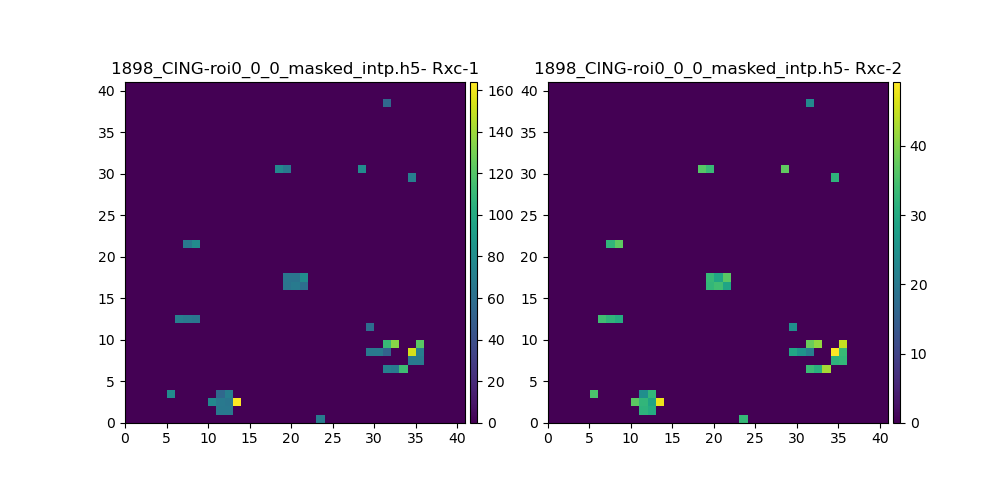

In [5]:
#### generate Radius of gyration
%matplotlib widget

from tqdm import tqdm

# specs
file = "1898_CING-roi0_0_0_masked_intp.h5"
Nsplits  = 2                                        # number of lines to fit
StartIdx = 4                                        # including start index
LastIdx  = 52                                       # Excluding last index
bkg_frame    = 379
max_frames = 40                                     # first 100 frame values
Rxc_str = ['Rxc-1', 'Rxc-2',]                       # names for slopes 

# new part
data = Data_Analysis(file, qgrid2, directory = cwd) # read data
IqBS = data.bkg_sub(bkg_frame = bkg_frame)          # background subtraction

df_IqBS = pd.DataFrame(IqBS)                        # convert to dataframe
list_max_frames = df_IqBS.sort_values(5,ascending=False)[:max_frames].index.to_list()   # 5-->th column values sorted in descending order and taking max 40 frames intensity to fit lines except are zero
print(list_max_frames)
Rxc = {}
n_patterns = len(IqBS)

for rxc_str in Rxc_str:
    Rxc[rxc_str] = np.zeros(n_patterns)     # except list_max_frames all values are zero

    for frame in tqdm(list_max_frames):
        df = optimize_best_lines(IqBS[frame], qgrid2, Nsplits, LastIdx, StartIdx,)   # get dataframe for the optimized one
        try:
            Rxc[rxc_str][frame] = df.iloc[df['rsq'].idxmax()][rxc_str]    
        except:
            print(f'Frame = {frame} {rxc_str} optimization failed - setting it to zero')
            Rxc[rxc_str][frame] = 0                 # set to zero in nan is found in try section
        
# plot heat maps
Width, Height = width_height(file)
plt.close('all')
f, axs = plt.subplots(1, len(Rxc_str), num=f'{file} Heat maps', figsize=(10,5))
for i, rxc_str in enumerate(Rxc_str):
    diff_patterns = Rxc[rxc_str]
    img_orig = snaking(Width, Height, diff_patterns)
    
    plot_heat_map_from_data(img_orig, Width, Height, args = (f, axs[i]), title= f'{file}- {rxc_str}')

In [37]:
### get individual frame fitting of radius of gyration
%matplotlib widget
# specs
frame = 10
# verification
df = optimize_best_lines(IqBS[frame], qgrid2, Nsplits, LastIdx, StartIdx, print_summary=True, show_plot=True)
print(df)

No best indices to plot - ending here
    0   1   2   3  Tpoints-1  qgridL-1  qgridH-1  slope-1  Rxc-1  I(0)-1  \
0   4   6   6  52          2     0.009     0.011      NaN    NaN     NaN   
1   4   7   7  52          3     0.009     0.012      NaN    NaN     NaN   
2   4   8   8  52          4     0.009     0.013      NaN    NaN     NaN   
3   4   9   9  52          5     0.009     0.014      NaN    NaN     NaN   
4   4  10  10  52          6     0.009     0.015      NaN    NaN     NaN   
5   4  11  11  52          7     0.009     0.016      NaN    NaN     NaN   
6   4  12  12  52          8     0.009     0.017      NaN    NaN     NaN   
7   4  13  13  52          9     0.009     0.018      NaN    NaN     NaN   
8   4  14  14  52         10     0.009     0.019      NaN    NaN     NaN   
9   4  15  15  52         11     0.009     0.020      NaN    NaN     NaN   
10  4  16  16  52         12     0.009     0.021      NaN    NaN     NaN   
11  4  17  17  52         13     0.009     0.022  

/Users/bashit.a/Documents/Alzheimer/Codes/essential_func.py:961: RuntimeWarning: invalid value encountered in log
  IqQ = np.log(IqBS*qgrid)                            # background subtracted Iq
/Users/bashit.a/Documents/Alzheimer/Codes/essential_func.py:989: RuntimeWarning: invalid value encountered in sqrt
  df.loc[idx,f'Rxc-{i+1}'] = np.round(np.sqrt(-df.loc[idx,f'slope-{i+1}']*2),4)
/Users/bashit.a/Documents/Alzheimer/Codes/essential_func.py:1000: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  np.isnan(np.sum(df.iloc[df['rsq'].idxmax()]))                                 # plotting/summary is possible if rsq doesn't have all nan values means no idxmax


In [14]:
pd.set_option('display.max_columns',None)
df.style.background_gradient()
df[df['rsq'] > 1.9]                      # Nsplits
#df[df['rsq-3'] > 0.99]['Tpoints-3'].idxmax()      # Nsplits
#plot_linear_lines(xData, yData, best_indices)

,0,1,2,3,Tpoints-1,qgridL-1,qgridH-1,slope-1,Rxc-1,I(0)-1,rsq-1,std_err-1,Tpoints-2,qgridL-2,qgridH-2,slope-2,Rxc-2,I(0)-2,rsq-2,std_err-2,rsq
15,4,21,21,52,17,0.009,0.026,-3034.0206,77.8976,-1.1577,0.9833,102.0698,31,0.026,0.064,-754.9580,38.8576,-2.9477,0.9178,41.9448,1.9011
16,4,22,22,52,18,0.009,0.027,-2942.4942,76.7137,-1.1793,0.9823,98.8487,30,0.027,0.064,-732.7059,38.2807,-3.0032,0.9213,40.4761,1.9036
17,4,23,23,52,19,0.009,0.028,-2864.0013,75.6836,-1.1988,0.9820,94.1066,29,0.028,0.064,-711.5534,37.7241,-3.0565,0.9241,39.2524,1.9061
18,4,24,24,52,20,0.009,0.029,-2790.4296,74.7051,-1.2180,0.9817,89.8257,28,0.029,0.064,-691.2316,37.1815,-3.1083,0.9264,38.2136,1.9081
19,4,25,25,52,21,0.009,0.030,-2719.1768,73.7452,-1.2377,0.9812,86.3410,27,0.030,0.064,-671.6804,36.6519,-3.1587,0.9282,37.3610,1.9094
20,4,26,26,52,22,0.009,0.031,-2656.5444,72.8909,-1.2559,0.9812,82.2512,26,0.031,0.064,-654.3046,36.1747,-3.2041,0.9282,37.1324,1.9094
21,4,27,27,52,23,0.009,0.032,-2579.0927,71.8205,-1.2795,0.9791,82.2237,25,0.032,0.064,-634.8805,35.6337,-3.2554,0.9299,36.3363,1.9090
22,4,28,28,52,24,0.009,0.033,-2498.1648,70.6847,-1.3054,0.9762,83.2407,24,0.033,0.064,-614.1752,35.0478,-3.3108,0.9331,35.0597,1.9093
23,4,29,29,52,25,0.009,0.034,-2432.3019,69.7467,-1.3275,0.9750,81.1824,23,0.034,0.064,-596.9635,34.5532,-3.3575,0.9333,34.8315,1.9083
24,4,30,30,52,26,0.009,0.035,-2361.5673,68.7251,-1.3523,0.9727,80.6832,22,0.035,0.064,-578.3881,34.0114,-3.4085,0.9346,34.2199,1.9073


/var/folders/nk/89hkzs1118vd7g7w28qfmn0r0000gq/T/ipykernel_85104/1129179539.py:6: RuntimeWarning: invalid value encountered in log
  IqQ = np.log(IqBS[frame]*qgrid2)                         # background subtracted Iq


interactive(children=(IntRangeSlider(value=(2, 50), description='Q1', max=109), IntSlider(value=109, descripti…

Output()

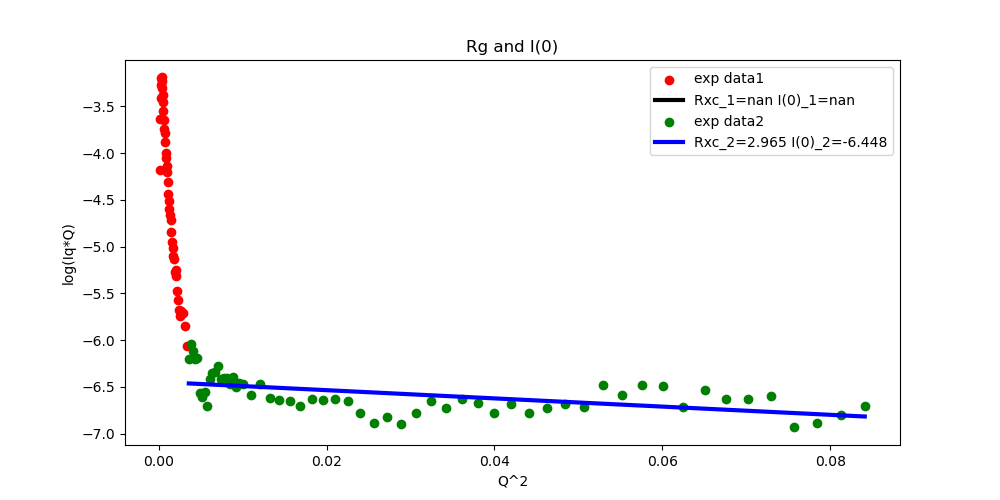

In [9]:
%matplotlib widget

# specs
frame = 1479    # 2048_B8_masked frame = 617 Rxc_2 = nan
QQ  = np.square(qgrid2)                            # squaring q values
IqQ = np.log(IqBS[frame]*qgrid2)                         # background subtracted Iq

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))          # plot figure   
out = ipywidgets.Output()

# semi specs
xData = QQ
yData = IqQ

# computation
@out.capture(clear=True)
def update_plot(Q1, Q2H):
    ax.clear()
    Q1L, Q1H = Q1
    plot_linear_lines(xData=xData, yData=yData, indices=[Q1L,Q1H,Q1H,Q2H], args=(f,ax))

Q1 =  ipywidgets.IntRangeSlider(min=0, max=109, value = [2, 50], step=1)
Q2H = ipywidgets.IntSlider(min=0, max=109, value = 109, step=1)

input = ipywidgets.interactive(update_plot, Q1=Q1, Q2H=Q2H)
display(input, out)